# Solving an inverse Problem with TorchPhysics and PINNs: Bonus Exercise 8b
Assume you are jumping from a plane with a parachute. Under some simplifications, your fall can be described by the following ODE:
\begin{align*}
    \begin{split}
        \partial_t^2 u(t) &= {\color{red}{D(t)}} \Big[\partial_t u(t)\Big]^2 - g  \text{ for } t\in I_t=[0,T], \\
        u(0) &= H, \\
        \partial_t u(0) &= v_0,
    \end{split}
\end{align*}
where $u : [0, T] \to \mathbb{R}$ is the height at time $t$, $H$ the starting height, $g$ the gravity constant, and $\color{red}{D(t)}$ a friction coefficient that is proportional to the cross section of the parachute at time $t$.

Given a noisy dataset $\{(u_i, t_i)\}_{i=1}^N$ of the height $u_i$ at time $t_i$, we aim to reconstruct the movement of the parachute described by $\color{red}{D(t)}$.

Again, we use a data condition for learning $u$ from the data. Moreover, since ${\color{red}{D(t)}}$ is only present in the PDE condition, we do not include the remaining conditions for additional loss terms. In other words, we train networks for $u$ and $D$ that minimize
$$
\frac{1}{N}\sum_{i=1}^N \vert u(t_i) - u_i \vert^2 + \frac{1}{M}\sum_{k=1}^M \left\vert \partial_t^2 u(\tilde{t}_k) - {\color{red}{D(\tilde{t}_k)}} \Big[\partial_t u(\tilde{t}_k)\Big]^2 + g \right\vert^2.
$$

In [ ]:
import pathlib
import os
gpu_device = str(int(str(pathlib.Path().resolve())[-2:]) % 8)
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

In [43]:
import torchphysics as tp
import pytorch_lightning as pl
import torch
import math
from matplotlib import pyplot as plt

# Here all parameters are defined:
g = 9.81                # Gravity constant
H = 0                   # Initial height H
v_0 = -1                # Initial velocity v_0
t_min, t_max = 0.0, 3.0 # Bounds for time interval

# Number of training points
N_pde = 3000

# Training parameters for ADAM optimizer
train_iterations = 5000
learning_rate = 1.e-3

Construct PyTorch dataset $\{(u_i, t_i)\}_{i=1}^N$. There is nothing TODO here.

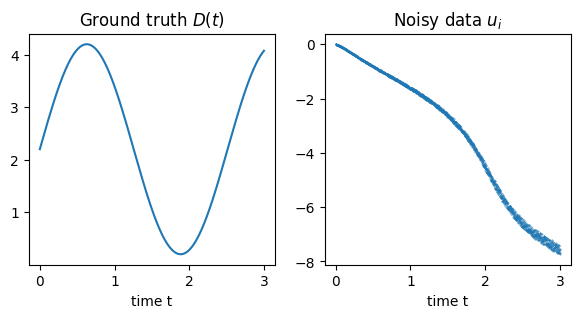

In [44]:
# The ground truth parameter D(t) we wish to reconstruct. It is used here to compute the solution data u_i
def D_groundtruth(t):
  return 2. * (1.1 + torch.sin(2.5*t))

# We use the explicit euler method for calculating the solution data u_i
# You don't have to read through the code, it is just for creating the dataset.
n_datapoints = 2000
t_data = torch.linspace(t_min, t_max, n_datapoints)
dt = t_data[1] - t_data[0]
u_data = torch.zeros_like(t_data)
velocity = torch.zeros_like(t_data)
u_data[0] = H
velocity[0] = v_0
for i in range(t_data.shape[0]-1):
  velocity[i+1] = velocity[i] + dt*(D_groundtruth(t_data[i])*velocity[i]**2-g)
  u_data[i+1] = u_data[i] + dt*velocity[i+1]

# We add 5% noise to the data u_i
u_data += torch.rand_like(u_data)*u_data*0.05

# Reshape t_data and u_data such that the shape is (n_datapoints, 1), respectively.
t_data = t_data.unsqueeze(1)
u_data = u_data.unsqueeze(1)

# Plot ground truth parameter D(t) and data u_i
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
ax1.plot(t_data[:, 0], D_groundtruth(t_data[:, 0]))
ax1.set_title(r'Ground truth $D(t)$')
ax1.set_xlabel('time t')
ax2.scatter(t_data[:, 0], u_data[:, 0], s=0.1)
ax2.set_title(r'Noisy data $u_i$')
ax2.set_xlabel('time t')
plt.show()

Spaces, domains and samplers

In [45]:
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')
# TODO: Create the output space of parameter function D
D = ...

# TODO: Define the time interval I_t
I_t = ...

# TODO: Create random uniform sampler for the PDE condition, which should hold on I_t. Use N_pde as the number of sampling points
pde_sampler = ... 

Transfer dataset into TorchPhysics Points

In [46]:
# In order to work with the data in TorchPhysics,
# we need to transform the data into `tp.spaces.Points` objects.
t_data_points = tp.spaces.Points(t_data, T)

# TODO: Do the same for out_data, but note: the output space is U.
u_data_points = ...

# TODO: Create a DataLoader, that loads combinations of t_data_points and u_data_points.
# Hint: This is analogous to Exercise_8.
data_loader = tp.utils.PointsDataLoader(..., batch_size=len(t_data))

Proceed with familiar TorchPhysics pipeline: Create models, residual functions and conditions

In [47]:
# We use the same model archiecture for u as in Exercise 8
model_u = tp.models.FCN(input_space=T, output_space=U, hidden = (50, 50))

# TODO: Create a FCN for the parameter function D(t). Use hidden=(30, 30, 30)
model_D = tp.models.FCN(...)

# We want to train the model for u and for D in parallel. For that, we define a parallel model in TorchPhysics:
model = tp.models.Parallel(model_u, model_D)

In [48]:
# TODO: Create a residual for the PDE condition
def pde_residual(...):
  return ...

# TODO: Create corresponding TorchPhysics condition
pde_condition = tp.conditions.PINNCondition(...)

A DataCondition minimizes the distance between the outputs of the NN and given data points.

In [49]:
## Again, we need a data condition, which is analogous to Exercise 8.
data_condition = tp.conditions.DataCondition(module=model_u,
                                             dataloader=data_loader,
                                             norm=2,
                                             use_full_dataset=True,
                                             weight=50)

## Training with the Adam optimizer

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=learning_rate)
solver = tp.solver.Solver(train_conditions=[data_condition, pde_condition], optimizer_setting=optim)


trainer = pl.Trainer(devices=1, accelerator="cpu", # use one GPU
                     max_steps=3000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False)

trainer.fit(solver)

Optional: try to improve the results by using LBFGS, a second-order optimizer that works only with constant inputs in every iteration.

In [ ]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.LBFGS, lr=0.1, optimizer_args={'max_iter': 3})
pde_condition.sampler = tp.samplers.GridSampler(I_t, 2000).make_static() # We use a static sampler to save time (static means: points are sampled beforehand and not every training step)
solver = tp.solver.Solver([data_condition, pde_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="cpu",
                     max_steps=1000,
                     logger=False,
                     benchmark=True)

trainer.fit(solver)

In [ ]:
# We plot the parameter function D that we learned
from matplotlib import pyplot as plt

plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_D, lambda D: D, plot_sampler, label=r'Trained parameter $D$')

# Plot ground truth D(t)
ts = torch.linspace(t_min, t_max, 1000)
plt.plot(ts, D_groundtruth(ts), label=r'Ground truth $D$')
plt.legend()
plt.show()

In [ ]:
# Plot learned solution u(t)
plot_domain = tp.domains.Interval(T, t_min, t_max)
plot_sampler = tp.samplers.PlotSampler(plot_domain, 1000)
fig = tp.utils.plot(model_u, lambda u: u, plot_sampler, label=r'Learned solution $u$')
plt.plot(torch.linspace(t_min, t_max, 2000), u_data, zorder=1, label='Noisy data u_i')
plt.legend()
plt.show()